This is a fun exercise, I liked the heatmap so I had to share!

#### Questions:
1. Identify pockets in San Francisco with a high concentration of active businesses. Please provide visualization(s) to support your analysis.
2. To promote growth in less popular industries in San Francisco, the county is offering a tax break for new businesses in these categories to encourage them set up shop in San Francisco. Identify the NAICS code and description of businesses that would benefit from this scheme.
3. What are the different industry types that have emerged in San Francisco over the years. Are there any trends you can identify?
4. If you had more time, what other conclusions might you be able to draw from this data? What interesting stories might you be able to tell?

In [8]:
# Imports & Settings
%run settings.py
%matplotlib inline

!ls

Emotion-detection              map_zoomed.png
README.md                      settings.py
SF_Registered_Businesses.ipynb sf_business_dataset.csv
map.png


In [9]:
# Read data in, encoding error for utf-8
df = pd.read_csv('sf_business_dataset.csv', encoding='latin-1', 
                 parse_dates=['Business Start Date', 'Business End Date'],
                 infer_datetime_format=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216649 entries, 0 to 216648
Data columns (total 26 columns):
Location Id                            216649 non-null object
Business Account Number                216649 non-null int64
Ownership Name                         216649 non-null object
DBA Name                               216649 non-null object
Street Address                         216645 non-null object
City                                   216380 non-null object
State                                  215969 non-null object
Source Zipcode                         216552 non-null float64
Business Start Date                    216649 non-null datetime64[ns]
Business End Date                      43979 non-null datetime64[ns]
Location Start Date                    216649 non-null object
Location End Date                      60244 non-null object
Mail Address                           216647 non-null object
Mail City                              216597 non-null object
Mail Zi

In [10]:
# Overview of df
pd.concat([df.head(2), df.tail(2)])

,Location Id,Business Account Number,Ownership Name,DBA Name,Street Address,City,State,Source Zipcode,Business Start Date,Business End Date,Location Start Date,Location End Date,Mail Address,Mail City,Mail Zipcode,Mail State,NAICS Code,NAICS Code Description,Parking Tax,Transient Occupancy Tax,LIC Code,LIC Code Description,Supervisor District,Neighborhoods - Analysis Boundaries,Business Corridor,Business Location
0,0026883-11-001,26883,Chevron Texaco Corp,Chevron,2998 San Jose Av,San Francisco,CA,94112.0,1968-10-01,NaT,1/31/1977,NaN,6001 Bollinger Canyon Rd V2002,San Ramon,94583,CA,NaN,NaN,False,False,NaN,NaN,11.0,Oceanview/Merced/Ingleside,NaN,"2998 SAN JOSE AV\rSan Francisco, CA 94112\r(37.711486, -122.45562)"
1,0026883-12-001,26883,Chevron Texaco Corp,Chevron,301 Claremont Blvd,San Francisco,CA,94127.0,1968-10-01,NaT,1/31/1977,NaN,6001 Bollinger Canyon Rd V2002,San Ramon,94583,CA,NaN,NaN,False,False,NaN,NaN,7.0,West of Twin Peaks,NaN,"301 CLAREMONT BLVD\rSan Francisco, CA 94127\r(37.7405, -122.465095)"
216647,1148560-05-171,1064579,"Outschool, Inc.",Outschool,645 7th St,San Francisco,CA,94103.0,2015-01-31,NaT,5/31/2017,NaN,645 7th St,San Francisco,94103,CA,5100-5199,Information,False,False,NaN,NaN,NaN,NaN,NaN,NaN
216648,1148606-05-171,1071093,Petru Vdovicenco,Itf Sf Taekwon-Do,2460 Sutter St,San Francisco,CA,94115.0,2017-05-31,NaT,5/31/2017,NaN,2460 Sutter St,San Francisco,94115,CA,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN


### Q1 
1. Identify pockets in San Francisco with a high concentration of active businesses. Please provide visualization(s) to support your analysis.

In [11]:
# Looking for just San Francisco
df.City.value_counts()

San Francisco    154100
San+francisco     14416
Oakland            4073
Daly+city          2605
San+jose           1744
Hayward            1234
Richmond           1194
Sacramento         1062
San+mateo           831
San+leandro         798
                  ...  
Honolulu              1
Marin City            1
Mira Loma             1
San+ysidro            1
Del+mar               1
S Francisco           1
Sunnyvake             1
Medway                1
San+mateo,            1
Northwood             1
Name: City, Length: 2336, dtype: int64

In [12]:
def clean_text(df, text_field):
    ''' Cleans a column in a df '''
    df[text_field] = df[text_field].str.replace(r"+", " ")
    df[text_field] = df[text_field].str.lower()

# Conditions for finding San Francisco-like cities
def san_franciscenize_geo(df):
    ''' This cleans the data specifically for geolocation data '''
    
    # Looking at active businesses
    df = df[df['Business End Date'].isnull()]
    
    # Cleaning City column
    clean_text(df, 'City')
    
    # Matching SF businesses
    mask = (df.City.str.startswith('san', na=False) & 
            df.City.str.contains('fran', na=False) &
            ~df.City.str.contains('south', na=True)
           )

    # New dataframe with selected city of interest
    df.City.where(~mask, 'san francisco', inplace=True)
    df = df[df.City == 'san francisco']

    # 2 Street Addresses are missing
    df = df[~df['Street Address'].isnull()]

    # Zipcodes will live within this range
    mask = ((df['Source Zipcode'] >= 94102) & 
            (df['Source Zipcode'] <= 94188))
    df = df[mask]
    print(df.City.value_counts())

    # State should be all CA by now
    df.State = 'CA'
    return df

df = san_franciscenize_geo(df)

san francisco    134925
Name: City, dtype: int64


In [13]:
# Getting the available latitude longitudes from the business location text
def extract_coord(x):
    try:
        return re.search(r'\(([0-9].*?)\)', x).group(1).split(',')
    except:
        return None
df['coord'] = df['Business Location'].apply(extract_coord)
missing = sum(df.coord.isnull())/len(df.coord)*100
print('Missing {:.1f}% of latitude longitude coordinates'.format(missing))

# Reducing the dataframe to the location data
locations = df.coord
locations = locations[~locations.isnull()]
locations = list(filter(lambda x: len(x) == 2, locations))

# Collecting the latitudes and longitudes for plotting
latitude, longitude = [float(x[0].strip()) for x in locations], \
                      [float(x[1].strip()) for x in locations]

Missing 16.4% of latitude longitude coordinates


I wanted to convert street addresses to coordinates because there were coordinates missing. The process ended up taking too long so I used the above solution.

In [14]:
# # Creating a full address for geocoding
# locations = df[['Location Id', 'Street Address', 'City', 'State', 'Source Zipcode']]
# locations['zipcode'] = locations['Source Zipcode'].astype(int).astype(str)
# locations.drop('Source Zipcode', axis=1, inplace=True)
# locations['address'] = locations['Street Address'] + ', San Francisco, CA ' + \
#                        locations['zipcode']

    
# # Method 1 for converting addresses to coordinates
# from geopy.geocoders import Nominatim
# geolocator = Nominatim()

# def geocoder(x):
#     try:
#         result = geolocator.geocode(x)
#         return (result.latitude, result.longitude)
#     except:
#         return None

# locations['latlong'] = np.NaN
# locations['latlong'] = list(map(geocoder, locations.address))

# # Method 2
# import googlemaps
# gmaps = googlemaps.Client(key='API Key')
# geocode_result = gmaps.geocode('1600 Amphitheatre Parkway, Mountain View, CA')

# # Method 3
# import requests
# site = 'https://maps.googleapis.com/maps/api/geocode/json'
# address = '?address=1600+Amphitheatre+Parkway,+Mountain+View,+CA'
# response = requests.get(site+address)
# resp_json_payload = response.json()
# print(resp_json_payload['results'][0]['geometry']['location'])

In [15]:
# Can insert API key and run the last line `fig` for interactive visual
gmaps.configure(api_key="API Key")

# Cropping output
layout = {
    'width': '700px',
    'height': '700px',
}

# Creating basemap
fig = gmaps.figure(center=(37.758, -122.44), zoom_level=12.5, layout=layout)

# Plot data as heatmap
heatmap_layer = gmaps.heatmap_layer(
    list(zip(latitude, longitude)), max_intensity=100, point_radius=5)
fig.add_layer(heatmap_layer)
#fig # Screenshot provided

Here is the above in a snapshot:
![Map1](./map.png)

In [16]:
# Zooming in and out changes the scaling
# These values can be modified in real time to provide a different view
# hint: uncomment fig with API key
heatmap_layer.max_intensity = 30
heatmap_layer.point_radius = 3

In [17]:
# We can make different maps
# Creating basemap
fig = gmaps.figure(center=(37.758, -122.42), zoom_level=13.5, layout=layout)

# Plot data as heatmap
heatmap_layer = gmaps.heatmap_layer(
    list(zip(latitude, longitude)), max_intensity=200, point_radius=15
)
fig.add_layer(heatmap_layer)
#fig # Screenshot provided

![Map-Zoomed](./map_zoomed.png)

Looking through interactively, I found that there are pockets of strong activity in the following places: Haight-Ashbury, between 16th St Mission Bart and 24th St Mission Bart, Noe Valley, in the Castro, SFSU & UCSF, West Portal, Dogpatch, near AT&T Park, a bit in Hayes Valley, east of Cow Hollow, and Presidio Heights, but most businesses are in the Financial District and SOMA.

### Q2
<span>2.</span> To promote growth in less popular industries in San Francisco, the county is offering a tax break for new businesses in these categories to encourage them set up shop in San Francisco. Identify the NAICS code and description of businesses that would benefit from this scheme.

In [18]:
# Resetting data
df = pd.read_csv('sf_business_dataset.csv', encoding='latin-1', 
                 parse_dates=['Business Start Date', 'Business End Date'],
                 infer_datetime_format=True)

# Conditions for finding San Francisco-like cities
def san_franciscenize_cat(df):
    ''' This preparess the data specifically for category data '''
    
    # Cleaning City column
    clean_text(df, 'City')
    
    # Matching SF businesses
    mask = (df.City.str.startswith('san', na=False) & 
            df.City.str.contains('fran', na=False) &
            ~df.City.str.contains('south', na=True)
           )

    # New dataframe with selected city of interest
    df.City.where(~mask, 'san francisco', inplace=True)
    df = df[df.City == 'san francisco']
    
    # Valid categories selection
    df = df[~df['NAICS Code'].isnull()]
    df = df[df['Business Start Date'] <= '2018-01-01']
    
    print(df.City.value_counts())
    return df

df = san_franciscenize_cat(df)

san francisco    98336
Name: City, dtype: int64


In [19]:
naics = df[['Business Account Number', 'Business Start Date', 
            'Business End Date', 'NAICS Code', 'NAICS Code Description',
            'LIC Code', 'LIC Code Description']]
naics.head(3)

,Business Account Number,Business Start Date,Business End Date,NAICS Code,NAICS Code Description,LIC Code,LIC Code Description
17,26924,1968-10-01,NaT,2300-2399,Construction,NaN,NaN
18,26924,1968-10-01,NaT,2300-2399,Construction,NaN,NaN
19,27082,1968-10-01,NaT,4200-4299,Wholesale Trade,NaN,NaN


In [20]:
# Creating an age column
now = datetime.datetime.now()
naics['Business End Date'] = pd.to_datetime(naics['Business End Date'].fillna(now))
naics['age'] = ((naics['Business End Date']-naics['Business Start Date'])/np.timedelta64(1, 'D')).astype(int)

# Checking data quality
naics.groupby('NAICS Code')['NAICS Code Description'].agg(['count', 'unique', 'nunique'])

,count,unique,nunique
NAICS Code,,,
2200-2299,106,[Utilities],1
2300-2399,5273,[Construction],1
3100-3399,1384,[Manufacturing],1
4200-4299,2662,[Wholesale Trade],1
4400-4599,9454,[Retail Trade],1
4800-4999,8145,[Transportation and Warehousing],1
5100-5199,2719,[Information],1
5210-5239,3187,[Financial Services],1
5240-5249,528,[Insurance],1


In [21]:
# Categories 8100-8139, 8100-8399, 8110-8139 appear to be the same
# Aggregating these codes
mask = ((naics['NAICS Code'] == '8100-8139') |
        (naics['NAICS Code'] == '8110-8139') |
        (naics['NAICS Code'] == '8100-8399'))

naics['NAICS Code Description'].where(~mask, other='Certain Services', inplace=True)
naics['NAICS Code'].where(~mask, other='8100-8399', inplace=True)
aggregation = naics.groupby('NAICS Code')['NAICS Code Description'] \
                   .agg(['count', 'unique'])
aggregation

,count,unique
NAICS Code,,
2200-2299,106,[Utilities]
2300-2399,5273,[Construction]
3100-3399,1384,[Manufacturing]
4200-4299,2662,[Wholesale Trade]
4400-4599,9454,[Retail Trade]
4800-4999,8145,[Transportation and Warehousing]
5100-5199,2719,[Information]
5210-5239,3187,[Financial Services]
5240-5249,528,[Insurance]


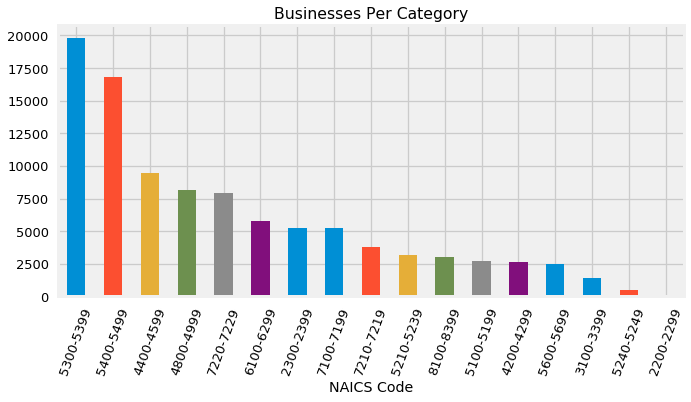

In [22]:
(aggregation['count'].sort_values(ascending=False)
                     .plot(
                         x=aggregation.index, y='count',
                         kind='bar', figsize=(10,5),
                         rot=70, title='Businesses Per Category',
                         legend=False, sort_columns=True, 
                     )
);

Below is a table of the lowest ranking categories:

NAICS Code| Count | Description
--- | --- | ---
2200-2299 | 106 | [Utilities]
5240-5249 |	528 | [Insurance]
3100-3399 |	1384 | [Manufacturing]
5600-5699 |	2506 |	[Administrative and Support Services]
4200-4299 |	2662 |	[Wholesale Trade]
5100-5199 |	2719 |	[Information]

Unsurprisingly, Utilities and Manufacturing are low ranking, likely due to the nature of the business. Tax breaks could sufficiently incentivize new insurance companies, wholesale traders, and information companies to bring new business to the City.

### Q3
<span> 3. </span> What are the different industry types that have emerged in San Francisco over the years. Are there any trends you can identify?

In [23]:
# What category is the youngest overall?
naics.groupby('NAICS Code')['age'].agg(['mean', 'count']).sort_values('mean')

,mean,count
NAICS Code,,
4800-4999,1640.224678,8145
7210-7219,2873.061359,3781
5100-5199,3267.203751,2719
7220-7229,3759.021558,7932
7100-7199,3859.813647,5232
5210-5239,4133.757452,3187
5400-5499,4198.385887,16821
2200-2299,4483.471698,106
2300-2399,4510.681965,5273


In [24]:
# Which category has the most new businesses?
mask = naics['Business Start Date'] >= '2016-01-01'
new = \
(naics[mask].groupby('NAICS Code')['age']
            .agg(['mean', 'count'])
            .sort_values('count', ascending=True)
            .reset_index()
            .rename(columns={'mean':'new_m', 'count':'new_c'})
)

# Comparisons over time
mask = ((naics['Business Start Date'] < '2016-01-01') &
        (naics['Business Start Date'] >= '2000-01-01'))
mid = \
(naics[mask].groupby('NAICS Code')['age']
            .agg(['mean', 'count'])
            .sort_values('count', ascending=True)
            .reset_index()
            .rename(columns={'mean':'mid_m', 'count':'mid_c'})
)


# Comparisons over time
mask = naics['Business Start Date'] < '2000-01-01'
old = \
(naics[mask].groupby('NAICS Code')['age']
            .agg(['mean', 'count'])
            .sort_values('count', ascending=True)
            .reset_index()
            .rename(columns={'mean':'old_m', 'count':'old_c'})
)

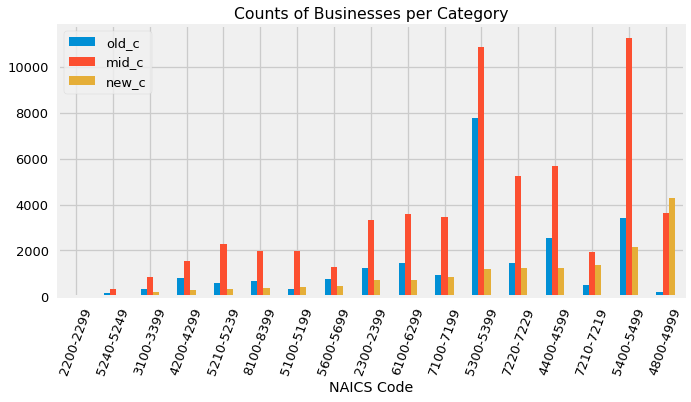

In [25]:
# Combining the time periods
dfs = [new,mid,old]
time = reduce(lambda left,right: pd.merge(left, right, on='NAICS Code'), dfs)

# Plotting the raw counts to compare across time periods
time.plot(x='NAICS Code', y=['old_c','mid_c','new_c'], kind='bar', 
          figsize=(10,5), rot=70, title='Counts of Businesses per Category');

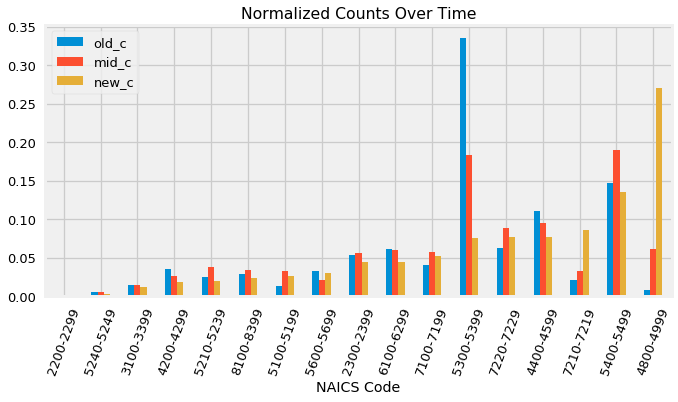

In [26]:
# Normalizing time period counts
new.new_c = new.new_c/sum(new.new_c)
mid.mid_c = mid.mid_c/sum(mid.mid_c)
old.old_c = old.old_c/sum(old.old_c)

dfs = [new,mid,old]
time = reduce(lambda left,right: pd.merge(left, right, on='NAICS Code'), dfs)

# Plotting the raw counts to compare across time periods
time.plot(x='NAICS Code', y=['old_c','mid_c','new_c'], kind='bar', 
          figsize=(10,5), rot=70, title='Normalized Counts Over Time');

The above makes assumptions that looking at percent of market is representative enough to draw conclusions. Below I will explain what would be a better approach.

This normalized plot makes it easy to see that some categories have been on a steady decline and some have been on a steady increase.

Most notably, Real Estate, Rental and Leasing Services [5300-5399] have seen the sharpest downtrend, whereas Transportation and Warehousing [4800-4999] experienced the greatest trend upwards.

Declining:

NAICS Code| Description
---       | --- 
5240-5249 | Insurance
3100-3399 |	Manufacturing
4200-4299 |	Wholesale Trade
6100-6299 |	Private Education and Health Services
5300-5399 | Real Estate and Rental and Leasing Services
4400-4599 | Retail Trade

Increasing:

NAICS Code| Description
---       | --- 
7210-7219 |	Accommodations
4800-4999 |	Transportation and Warehousing

Middleground:

NAICS Code| Description
---       | --- 
2200-2299 | Utilities
5210-5239 |	Financial Services
8100-8399 |	Certain Services
5100-5199 |	Information
5600-5699 | Administrative and Support Services
2300-2399 | Construction
7100-7199 | Arts, Entertainment, and Recreation
7220-7229 | Food Services
5400-5499 | Professional, Scientific, and Technical Services

### Q4
These 3 time periods were picked arbitrarily for preliminary analysis. It would be better to break out each year and look at changes more granularly, also this does not take into account for businesses that may pop up for less than a year. If we wanted to make a policy change I would also ook into the survival of different businesses in each category.

To go to the extreme I would like to visualize trends over time with a sliding controllable window in D3, which might be overkill but would be interesting to see. This idea could be combined with the heatmap and filters to create a full understanding of the data in both time and space.

There were other cities included. If we were to clean the heck out of this dataset (or if it was actually complete) we could start looking at a larger area in more detail to find out which industries are moving in and which are moving out.